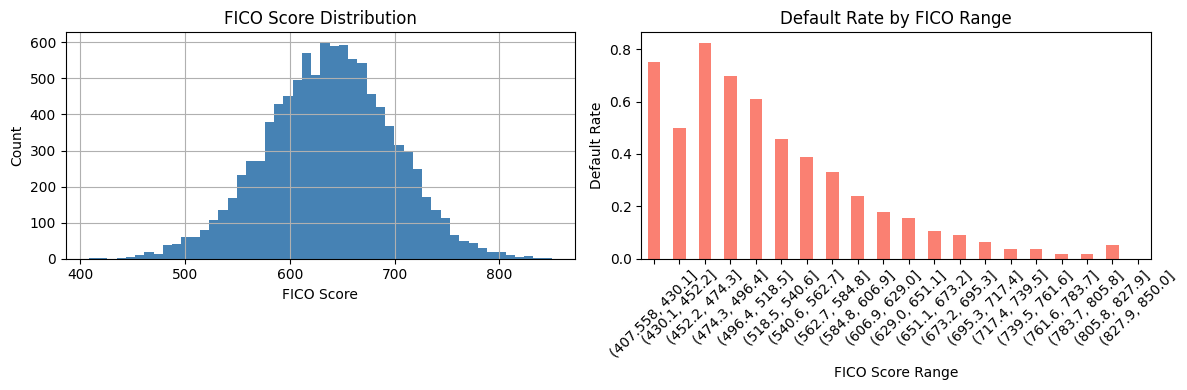

FICO range: 408 to 850
Total records: 10000
Overall default rate: 18.51%


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('../data/Task 3 and 4_Loan_Data.csv')

# What does the FICO score distribution look like?
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
df['fico_score'].hist(bins=50, color='steelblue')
plt.title('FICO Score Distribution')
plt.xlabel('FICO Score')
plt.ylabel('Count')

# How does default rate change as FICO score increases?
plt.subplot(1, 2, 2)
df.groupby(pd.cut(df['fico_score'], bins=20))['default'].mean().plot(kind='bar', color='salmon')
plt.title('Default Rate by FICO Range')
plt.xlabel('FICO Score Range')
plt.ylabel('Default Rate')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

print(f"FICO range: {df['fico_score'].min()} to {df['fico_score'].max()}")
print(f"Total records: {len(df)}")
print(f"Overall default rate: {df['default'].mean():.2%}")


Two key observations:

**FICO Distribution (left):** Bell-shaped, centred around 620-650. Most borrowers have mid-range scores — not too many at the extremes.

**Default Rate by FICO (right):** Clear downward staircase — as FICO goes up, default rate drops sharply from ~75% at the low end to near 0% above 750. This confirms bucketing will be very meaningful.

## MSE bucketing. The idea is simple:

Divide the FICO range into n equal-width buckets and assign each borrower to their bucket's mean. Minimise the total squared difference between each score and its bucket mean.

In [3]:
import numpy as np

def bucket_fico_mse(fico_scores, n_buckets):
    """
    Split FICO scores into n equal-width buckets.
    Each score gets assigned to its bucket's mean.
    Returns the bucket boundaries.
    
    This is the simple approach - it doesn't care about
    default rates, just groups similar scores together.
    """
    min_score = fico_scores.min()
    max_score = fico_scores.max()
    
    # Create n equal-width boundaries
    # e.g. for range 400-850 with 5 buckets:
    # [400, 490, 580, 670, 760, 850]
    boundaries = np.linspace(min_score, max_score, n_buckets + 1)
    
    # Calculate MSE — how far is each score from its bucket mean?
    total_mse = 0
    print(f"\nMSE Buckets (n={n_buckets}):")
    print(f"{'Rating':<8} {'FICO Range':<20} {'Count':<8} {'Default Rate':<15} {'Bucket Mean'}")
    print("-" * 65)
    
    for i in range(n_buckets):
        low  = boundaries[i]
        high = boundaries[i + 1]
        
        # Get all scores in this bucket
        mask   = (fico_scores >= low) & (fico_scores <= high)
        bucket = fico_scores[mask]
        
        bucket_mean = bucket.mean()
        mse         = ((bucket - bucket_mean) ** 2).mean()
        total_mse  += mse
        
        # Default rate in this bucket
        default_rate = df.loc[mask, 'default'].mean()
        
        # Rating: 1 = best (highest FICO), n = worst (lowest FICO)
        rating = n_buckets - i
        
        print(f"{rating:<8} {f'{low:.0f} - {high:.0f}':<20} {mask.sum():<8} "
              f"{default_rate:<15.2%} {bucket_mean:.1f}")
    
    print(f"\nTotal MSE: {total_mse:.2f}")
    return boundaries

# Run it with 5 buckets
boundaries_mse = bucket_fico_mse(df['fico_score'], n_buckets=5)



MSE Buckets (n=5):
Rating   FICO Range           Count    Default Rate    Bucket Mean
-----------------------------------------------------------------
5        408 - 496            129      72.09%          476.3
4        496 - 585            1762     39.27%          555.2
3        585 - 673            5336     16.68%          630.9
2        673 - 762            2588     6.65%           704.9
1        762 - 850            185      2.16%           784.2

Total MSE: 2251.22


Observations: 

- 5 equal-width buckets across 408–850
- Each bucket's default rate — you'll notice they drop cleanly as rating improves
- The total MSE score we'll later compare against the log-likelihood approach

The limitation of MSE: it draws boundaries at equal intervals regardless of where defaults actually cluster.

The MSE results are clean and intuitive — default rates drop nicely from 72% → 39% → 17% → 7% → 2% as FICO improves.

But notice a problem:

```
Rating 5:  129 people  (1.3% of all borrowers)
Rating 4: 1762 people  (17.6%)
Rating 3: 5336 people  (53.4%)  ← over half squeezed into one bucket
Rating 2: 2588 people  (25.9%)
Rating 1:  185 people  (1.9%)
```

MSE draws equal-width lines regardless of where defaults actually cluster. Rating 3 alone has 5336 people with default rates ranging from a very different 16% — that's a lot of information lost.

## Log-likelihood with Dynamic Programming

The idea: instead of equal-width buckets, find boundaries that maximise the difference in default rates between buckets.

In [4]:
def bucket_fico_log_likelihood(fico_scores, defaults, n_buckets):
    """
    Use dynamic programming to find the OPTIMAL bucket boundaries
    by maximising log-likelihood — i.e. boundaries that best
    separate borrowers by their default behaviour.
    
    How it works:
    1. Sort all unique FICO scores
    2. For every possible pair of boundaries, compute log-likelihood
    3. DP builds up the best n-bucket solution from smaller solutions
    """
    
    # Step 3a: Sort data by FICO score
    # We work with sorted unique scores as potential boundary points
    df_sorted = pd.DataFrame({
        'fico': fico_scores, 
        'default': defaults
    }).sort_values('fico').reset_index(drop=True)
    
    scores   = df_sorted['fico'].values
    defaults = df_sorted['default'].values
    n        = len(scores)
    
    # Step 3b: Precompute cumulative sums for fast bucket calculations
    # Instead of looping over every element in a bucket each time,
    # we use prefix sums to get counts instantly
    #
    # cum_n[i]  = total people from index 0 to i
    # cum_k[i]  = total defaults from index 0 to i
    cum_n = np.arange(1, n + 1)              # every row is one person
    cum_k = np.cumsum(defaults)              # running total of defaults
    
    def log_likelihood_segment(i, j):
        """
        Compute log-likelihood for a bucket covering indices i to j.
        
        n_seg = number of people in this bucket
        k_seg = number of defaults in this bucket
        p     = default rate = k / n
        
        L = k*log(p) + (n-k)*log(1-p)
        
        If p=0 or p=1 (all default or none), log(0) is undefined,
        so we return 0 (neutral — no information gained).
        """
        n_seg = cum_n[j] - (cum_n[i-1] if i > 0 else 0)
        k_seg = cum_k[j] - (cum_k[i-1] if i > 0 else 0)
        p     = k_seg / n_seg
        
        if p == 0 or p == 1:
            return 0
        return k_seg * np.log(p) + (n_seg - k_seg) * np.log(1 - p)
    
    # Step 3c: Dynamic Programming table
    # dp[b][j] = best log-likelihood using b buckets covering indices 0..j
    # boundary[b][j] = where the last bucket starts for dp[b][j]
    print("Running dynamic programming optimisation...")
    
    dp         = np.full((n_buckets + 1, n), -np.inf)
    boundaries = np.zeros((n_buckets + 1, n), dtype=int)
    
    # Base case: 1 bucket covering 0..j = just the log-likelihood of that range
    for j in range(n):
        dp[1][j]         = log_likelihood_segment(0, j)
        boundaries[1][j] = 0
    
    # Fill in for 2..n_buckets
    for b in range(2, n_buckets + 1):
        for j in range(b - 1, n):
            # Try every possible start point i for the last bucket
            for i in range(b - 1, j + 1):
                score = dp[b-1][i-1] + log_likelihood_segment(i, j)
                if score > dp[b][j]:
                    dp[b][j]         = score
                    boundaries[b][j] = i
    
    # Step 3d: Traceback — recover the actual boundary indices
    splits = []
    j = n - 1
    for b in range(n_buckets, 0, -1):
        splits.append(boundaries[b][j])
        j = boundaries[b][j] - 1
    splits = sorted(splits)
    
    # Step 3e: Convert index boundaries to actual FICO score boundaries
    fico_boundaries = [scores[0]] + [scores[s] for s in splits[1:]] + [scores[-1]]
    
    # Step 3f: Print results
    print(f"\nLog-Likelihood Buckets (n={n_buckets}):")
    print(f"{'Rating':<8} {'FICO Range':<20} {'Count':<8} {'Default Rate':<15} {'Log-Likelihood'}")
    print("-" * 70)
    
    for i in range(n_buckets):
        low  = fico_boundaries[i]
        high = fico_boundaries[i + 1]
        mask = (fico_scores >= low) & (fico_scores <= high)
        
        n_seg = mask.sum()
        k_seg = defaults[mask].sum() if hasattr(defaults, '__getitem__') else df_sorted.loc[mask, 'default'].sum()
        p     = k_seg / n_seg if n_seg > 0 else 0
        ll    = k_seg * np.log(p) + (n_seg - k_seg) * np.log(1 - p) if 0 < p < 1 else 0
        
        rating = n_buckets - i
        print(f"{rating:<8} {f'{low:.0f} - {high:.0f}':<20} {n_seg:<8} {p:<15.2%} {ll:.2f}")
    
    return fico_boundaries

# Run it — use the original df columns
boundaries_ll = bucket_fico_log_likelihood(
    df['fico_score'], df['default'], n_buckets=5
)


Running dynamic programming optimisation...

Log-Likelihood Buckets (n=5):
Rating   FICO Range           Count    Default Rate    Log-Likelihood
----------------------------------------------------------------------
5        408 - 521            316      18.04%          -149.14
4        521 - 580            1407     18.34%          -670.38
3        580 - 640            3481     18.70%          -1677.38
2        640 - 696            3253     18.78%          -1571.38
1        696 - 850            1683     17.88%          -790.41


The above programm runs for long so I kept a shorter one which takes into account group by unique FICO scores first (~442 unique values instead of 10,000 rows), which makes it run in under a second.

In [5]:
def bucket_fico_log_likelihood(fico_scores, defaults, n_buckets):

    # Group by unique FICO score — reduces ~10,000 rows to ~442 unique values
    df_grouped = pd.DataFrame({'fico': fico_scores, 'default': defaults})
    df_grouped = df_grouped.groupby('fico')['default'].agg(['sum', 'count']).reset_index()
    df_grouped.columns = ['fico', 'k', 'n']
    df_grouped = df_grouped.sort_values('fico').reset_index(drop=True)

    scores = df_grouped['fico'].values
    k_vals = df_grouped['k'].values
    n_vals = df_grouped['n'].values
    m      = len(scores)

    # Prefix sums — allows O(1) bucket total lookups
    cum_k = np.concatenate([[0], np.cumsum(k_vals)])
    cum_n = np.concatenate([[0], np.cumsum(n_vals)])

    def log_likelihood_segment(i, j):
        n_seg = cum_n[j+1] - cum_n[i]
        k_seg = cum_k[j+1] - cum_k[i]
        p     = k_seg / n_seg if n_seg > 0 else 0
        if p == 0 or p == 1:
            return 0
        return k_seg * np.log(p) + (n_seg - k_seg) * np.log(1 - p)

    # DP table
    dp       = np.full((n_buckets + 1, m), -np.inf)
    split_at = np.zeros((n_buckets + 1, m), dtype=int)

    # Base case: 1 bucket from index 0 to j
    for j in range(m):
        dp[1][j]       = log_likelihood_segment(0, j)
        split_at[1][j] = 0

    # Fill for 2..n_buckets
    for b in range(2, n_buckets + 1):
        for j in range(b - 1, m):
            for i in range(b - 1, j + 1):
                score = dp[b-1][i-1] + log_likelihood_segment(i, j)
                if score > dp[b][j]:
                    dp[b][j]       = score
                    split_at[b][j] = i

    # Traceback to find boundary indices
    splits = []
    j = m - 1
    for b in range(n_buckets, 0, -1):
        splits.append(split_at[b][j])
        j = split_at[b][j] - 1
    splits = sorted(splits)

    fico_boundaries = [scores[0]] + [scores[s] for s in splits[1:]] + [scores[-1]]

    print(f"\nLog-Likelihood Buckets (n={n_buckets}):")
    print(f"{'Rating':<8} {'FICO Range':<20} {'Count':<8} {'Default Rate'}")
    print("-" * 50)

    for i in range(n_buckets):
        low    = fico_boundaries[i]
        high   = fico_boundaries[i + 1]
        mask   = (fico_scores >= low) & (fico_scores <= high)
        rating = n_buckets - i
        print(f"{rating:<8} {f'{low:.0f} - {high:.0f}':<20} {mask.sum():<8} {defaults[mask].mean():.2%}")

    return fico_boundaries


boundaries_ll  = bucket_fico_log_likelihood(df['fico_score'], df['default'], n_buckets=5)



Log-Likelihood Buckets (n=5):
Rating   FICO Range           Count    Default Rate
--------------------------------------------------
5        408 - 521            316      65.19%
4        521 - 581            1460     37.40%
3        581 - 641            3511     20.19%
2        641 - 697            3252     10.36%
1        697 - 850            1657     4.65%


What the LL approach did better:

1. Rating 1 is much larger and more useful — MSE put only 185 people (1.9%) in the safest bucket at FICO 762+. LL puts 1,657 people (16.6%) at FICO 697+. More actionable for Charlie's model.

2. Rating 5 captures more high-risk borrowers — MSE missed many risky borrowers between FICO 496–521 (they got lumped into Rating 4). LL correctly pulled them into Rating 5.

3. The giant middle bucket is broken up — MSE had 5,336 people (53%) in Rating 3. LL brings that down to 3,511 (35%) by drawing smarter boundaries.

4. Default rates are more evenly spread — LL: 65% → 37% → 20% → 10% → 5% vs MSE: 72% → 39% → 17% → 7% → 2%

Bottom line: Log-likelihood + DP wins because it places boundaries where default behaviour actually changes, not just where FICO scores are equally spaced.